In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from pbo.utils.confidence_interval import confidence_interval

experiment_name = "b10_q30_30_b500_s2_pbo2_2_2_2_fpbo3000_25_lr5_r20000_idqn5000_80_w30_15"
show_dqn = True; show_pbo_linear = False; show_pbo_deep = True
max_bellman_iterations = 10
max_bellman_iterations_validation = max_bellman_iterations + 10
seeds = range(1, 41)

p = json.load(open(f"figures/{experiment_name}/parameters.json"))

n_seeds = len(seeds)
ticks_freq = 3

### Extract data

In [2]:
if show_dqn:
    dqn_j = np.zeros((n_seeds, max_bellman_iterations + 1))

    for idx_seed, seed in enumerate(seeds):
        dqn_j[idx_seed] = np.load(f"figures/{experiment_name}/DQN/{max_bellman_iterations}_J_{seed}.npy")

if show_pbo_linear:
    pbo_linear_j = np.zeros((n_seeds, max_bellman_iterations_validation + 2))

    for idx_seed, seed in enumerate(seeds):
        pbo_linear_j[idx_seed] = np.load(f"figures/{experiment_name}/PBO_linear/{max_bellman_iterations}_J_{seed}.npy")

if show_pbo_deep:
    pbo_deep_j = np.zeros((n_seeds, max_bellman_iterations_validation + 1))

    for idx_seed, seed in enumerate(seeds):
        pbo_deep_j[idx_seed] = np.load(f"figures/{experiment_name}/PBO_deep/{max_bellman_iterations}_J_{seed}.npy")

### Distances with the optimal Q function

In [3]:
if show_dqn:
    dqn_j_mean = dqn_j.mean(axis=0)
    dqn_j_std = dqn_j.std(axis=0)
    dqn_j_confidence_interval = confidence_interval(dqn_j_mean, dqn_j_std, n_seeds)

if show_pbo_linear:
    pbo_linear_j_mean = pbo_linear_j.mean(axis=0)
    pbo_linear_j_std = pbo_linear_j.std(axis=0)
    pbo_linear_j_confidence_interval = confidence_interval(pbo_linear_j_mean, pbo_linear_j_std, n_seeds)

if show_pbo_deep:
    pbo_deep_j_mean = pbo_deep_j.mean(axis=0)
    pbo_deep_j_std = pbo_deep_j.std(axis=0)
    pbo_deep_j_confidence_interval = confidence_interval(pbo_deep_j_mean, pbo_deep_j_std, n_seeds)

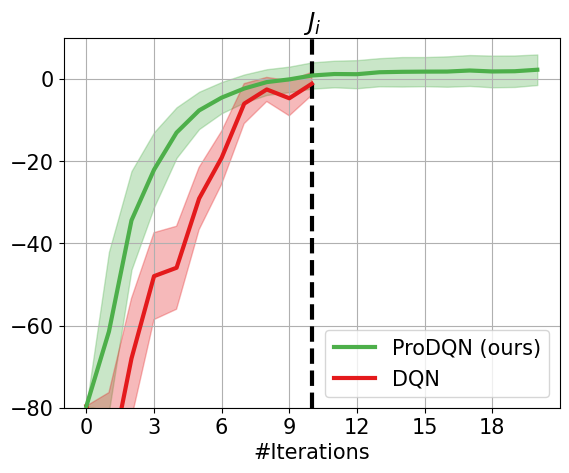

In [4]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

if show_pbo_linear:
    plt.plot(iterations_validation, pbo_linear_j_mean[:-1], label="linear PBO", color="blue", zorder=7)
    plt.fill_between(iterations_validation, pbo_linear_j_confidence_interval[0, :-1], pbo_linear_j_confidence_interval[1, :-1], color="blue", alpha=0.3)

    # plt.hlines(pbo_linear_q_mean[-1], 0, max_bellman_iterations_validation, color="blue", linestyle="--", label="linear PBO fixed point", zorder=3)
    # plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval[0, -1], pbo_linear_q_confidence_interval[1, -1], color="blue", alpha=0.3)

if show_pbo_deep:
    plt.plot(iterations_validation, pbo_deep_j_mean, label="ProDQN (ours)", color=colors["ProDQN"], zorder=8)
    plt.fill_between(iterations_validation, pbo_deep_j_confidence_interval[0], pbo_deep_j_confidence_interval[1], color=colors["ProDQN"], alpha=0.3)

if show_dqn:
    plt.plot(iterations, dqn_j_mean, label="DQN", color=colors["DQN"], zorder=6)
    plt.fill_between(iterations, dqn_j_confidence_interval[0], dqn_j_confidence_interval[1], color=colors["DQN"], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")
plt.ylim(-80, 10)
plt.title(r"$ J_i $")
plt.legend().set_zorder(9)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/J_{max_bellman_iterations}.pdf", bbox_inches='tight')